In [2]:
from IPython.display import Image

# Training Operationalization

Training operationalization is the process of `building and testing a repeatable ML training pipeline` and then `deploying it to a target execution environment.`


MLE should be able to use configurations to deploy the ML pieplines.
Configurations specify variables

- The target deployment environment (development, test, staging and so on).
- THe data sources to access during execution in each environment.
- The service account to use for running compute workloads.


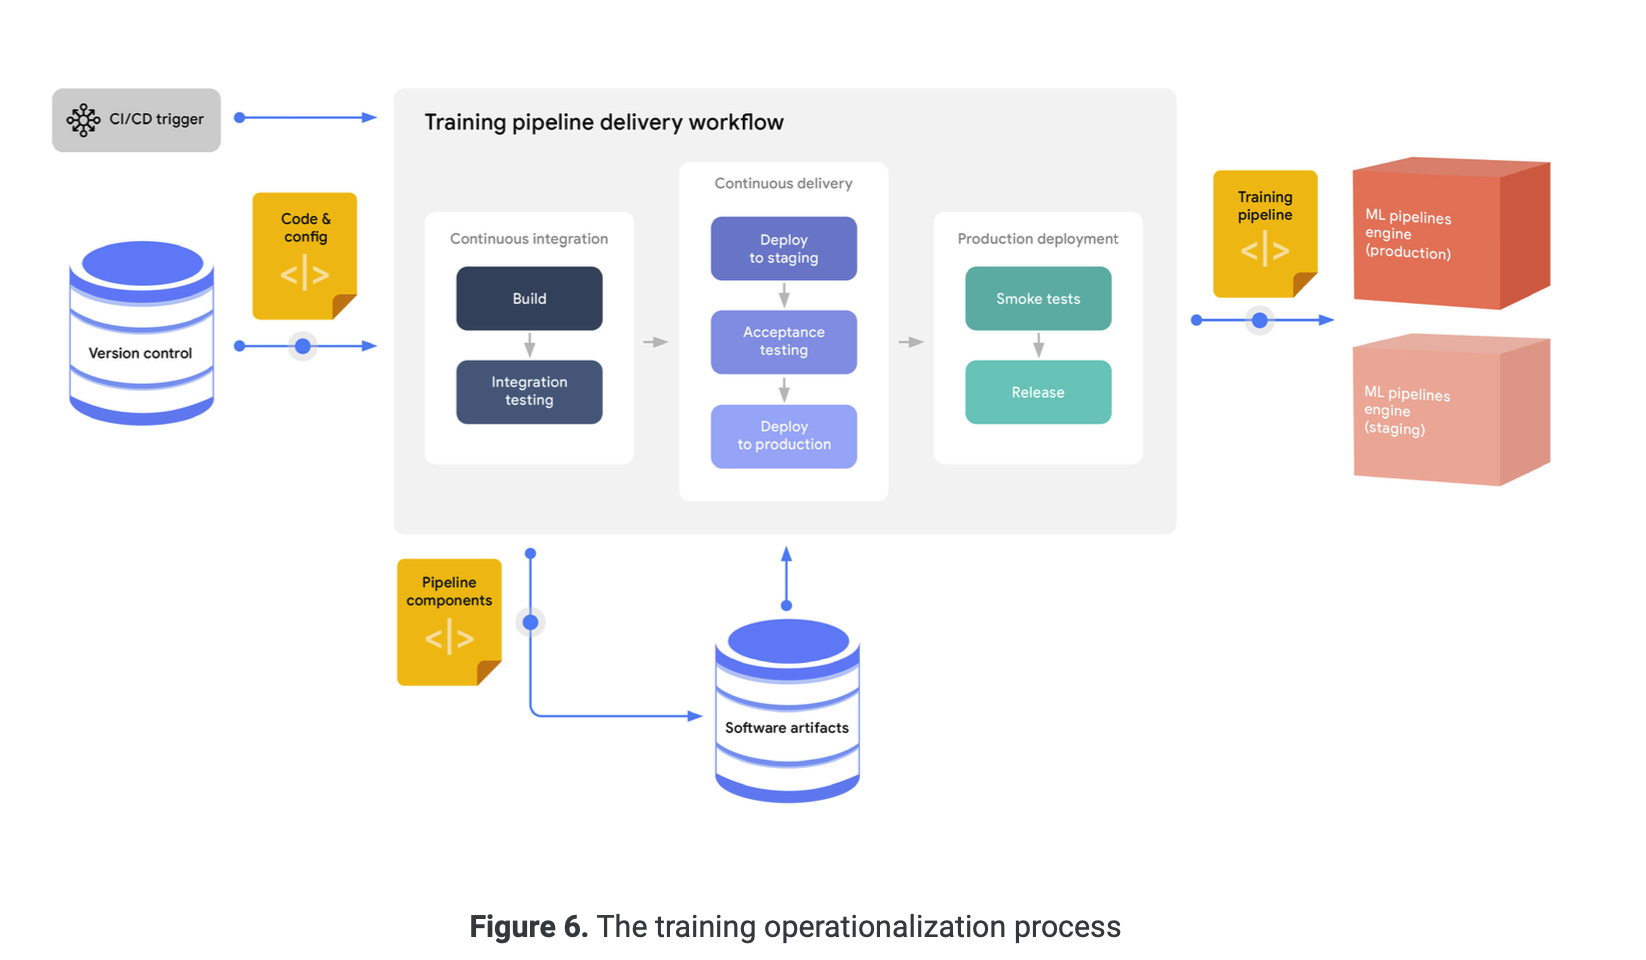

In [7]:
Image(
    "artifacts/training_operationalization_process.png",
    width=1000,
)

A pipeline should go through a serires of testing and staging envionrments before it is released to production.

1. In the CI stage, the source code is `unit-tested`, and the training pipeline is built and `integration-tested`.

```{note}
Artifacts created from this step are stored in an artifact repository.
For example,
- Container images stored in a container registry.
- Training-pipeline runtime representation, which references the components stored in an artifacts repository
```

2. In the middle CD (continuous delivery) stage, the tested training pipeline artifacts (artficats are exactly what CI has pushed to registry) are deployed to a staing env, where the pipeline goes through `end-to-end` and `acceptance` testing before being released to the prod env. Usually, pipelines are tested in non-prod environments on a subset of prod data, while the full-scale trianing is performed only in prod env.

3. The newly deployed training pipeline will be smoke-tested. Now, the pipeline is productionalized. If the new pipeline fails to product a deployable model, the model serving system can fall back to the model that was produced by the current training pipeline.

What are the difference between different tests?

| Test type              | Data size     | Goal                                        |
| ---------------------- | ------------- | ------------------------------------------- |
| Unit                   | none (mocked) | One function behaves correctly              |
| Smoke                  | kilobytes     | Whole pipeline starts & finishes            |
| Integration/Acceptance | MB–GB sample  | Functional correctness & minimal metric bar |
| Full retraining        | all prod data | Best model quality                          |


# Continuous Training

The continuous training process is about `orchestrating` and `automating` the execution of `training pipelines`.

```{note}
Retrain only when changing data or upside justifies it: in stable scenarios such as classifying images from a fixed source, model accuracy can hold for weeks or months, so daily retraining is wasteful. By contrast, shopping-site recommenders face continually shifting user behavior and inventory, so refreshing the model every few days (or even daily) captures new patterns and lifts click-throughs and sales. Choose a cadence that balances this business gain against the compute cost and latency of each run.
```

Pipeline can be triggered in the following ways:
- Scheduled runs based on jobs that you configure.
- Event-driven runs, such as when new data becomes available above a certain threshold, or when model decay is detected by the continuous monitoring process.
- Ad hoc runs based on manual invocation.

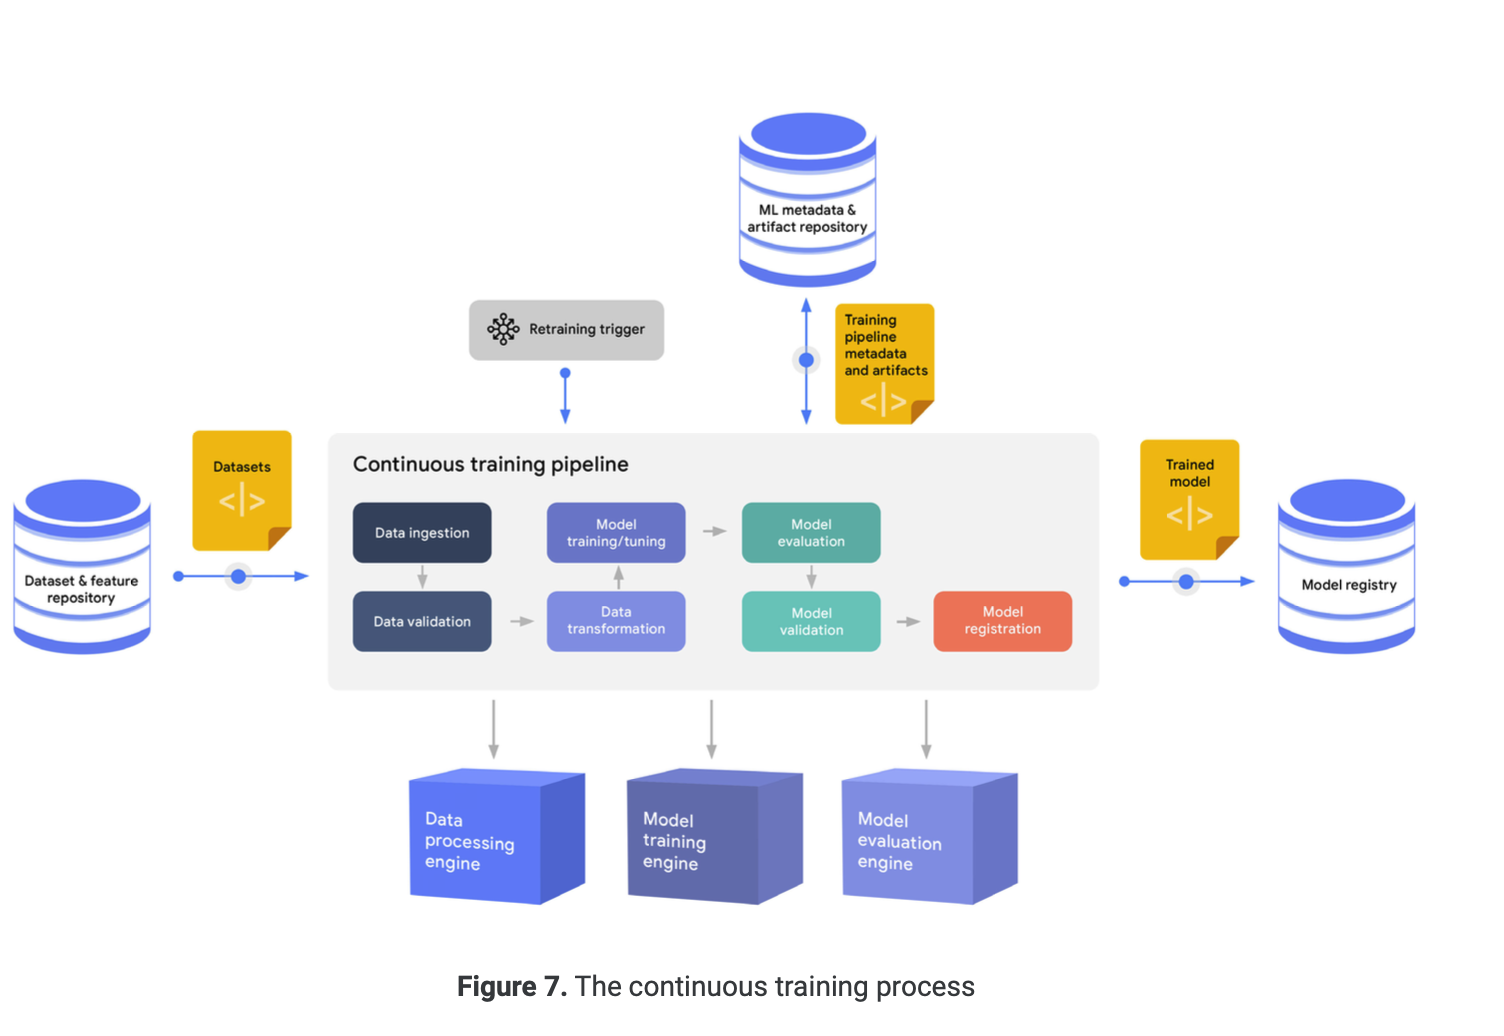

In [8]:
Image(
    "artifacts/continuous_training_process.png",
    width=1000,
)

The middle CT (Continuous training) pipeline typically includes
- Data ingestion. Training data is extracted from the source dataset and feature repository using filtering criteria such as the date and time of the most recent update.
- Data validation. The extracted training data is validated to make sure that the model is not trained using skewed or corrupted data.
- Data transformation. The data is split, typically into training, evaluation, and testing splits. The data is then transformed, and the features are engineered as expected by the model.
- Model training and tuning. The ML model is trained and the hyperparameters are tuned using the training and evaluation data splits to produce the best possible model.
- Model evaluation. The model is evaluated against the test data split to assess the performance of the model using various evaluation metrics on different partitions of the data.
- Model validation. The results of model evaluations are validated to make sure that the model meets the expected performance criteria.
- Model registration. The validated model is stored in a model registry along with its metadata.

As you can see, the CT pipeline runs based on a retraining trigger. When the pipeline starts, it
`extracts a fresh training dataset` from the dataset and feature repository, `executes the steps in the ML workflow`, and submits a trained model to the `model registry`. *All the run information and artifacts that are produced throughout the pipeline run are tracked in the metadata and artifact repository.

```{note}
An automated training pipeline closely follows the steps of the typical data science process used in ML development, but with key differences. In automation, data and model validation become critical gatekeepers, ensuring quality in the absence of manual oversight. As these unattended runs execute, changes in training and evaluation data can eventually render the pipeline’s data processing and training procedures suboptimal or even invalid.
```

**Data validation** detects anomalies such as new or missing features and shifts in feature distributions by comparing new data to the expected schema and reference statistics.

**Model validation** checks if new models improve or maintain performance, using evaluation metrics, sensitivity analysis, calibration, and fairness checks.

**Tracking and Lineage**
Continuous training requires tracking all pipeline metadata and artifacts for debugging, reproducibility, and lineage. Lineage links each trained model to its source data and all intermediate artifacts.
- Retrieve the hyperparameters that are used during training.
- Retrieve all evaluations that are performed by the pipeline.
- Retrieve processed data snapshots after transformation steps, if
feasible.
- Retrieve data summaries such as descriptive statistics, schemas,
and feature distributions.

When a pipeline run has finished and the model has been validated, the pipeline can register a model candidate in the model registry.

```{tips}
Automated pipelines can include deployment, creating an end-to-end training and deployment workflow. When models are retrained and deployed frequently, training and deployment are often combined, with extra checks like model size and serving latency. However, many organizations keep training and deployment separate, so most training pipelines stop after registering a validated model.
```

# Model deployment

*After a model has been trained, validated, and added to the model registry, it is ready for deployment.*

During deployment, the model is packaged, tested, and deployed to the target environment, often `after passing through testing and governance steps.`

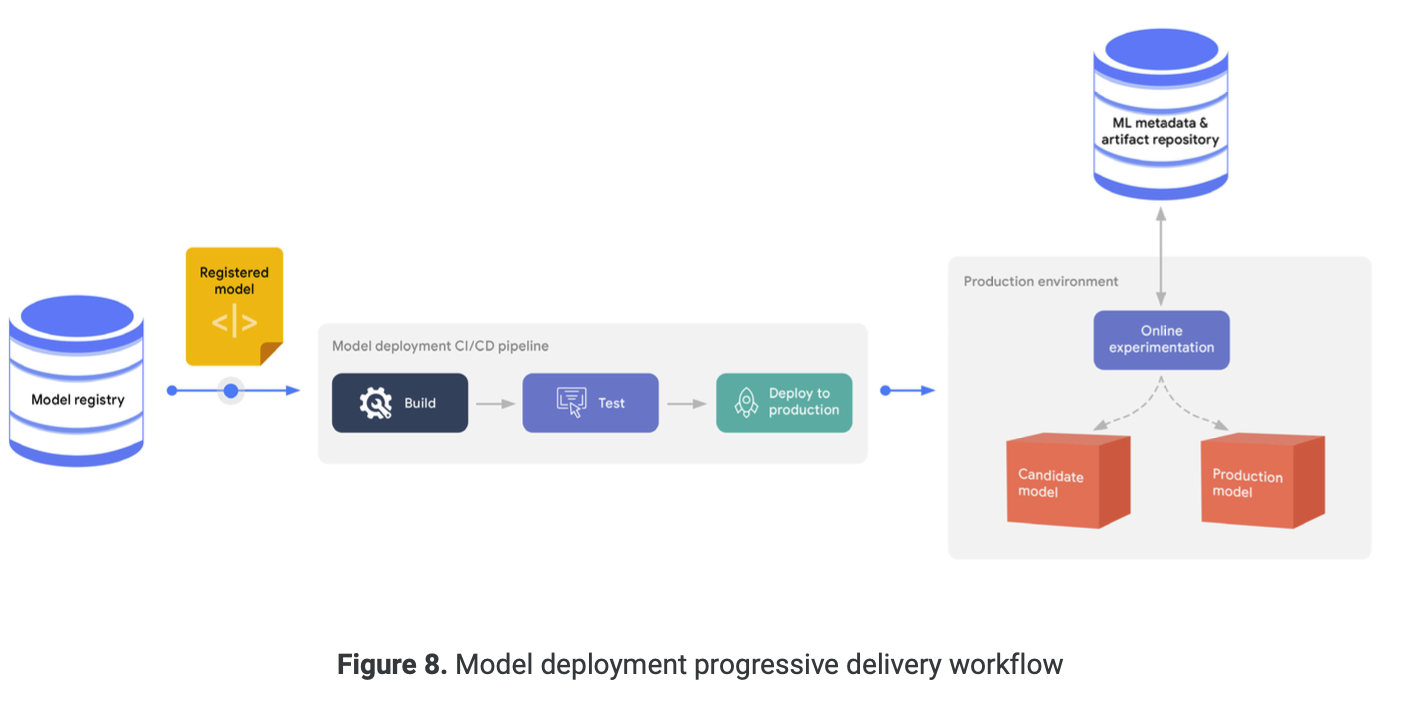

In [9]:
Image(
    "artifacts/model_deployment_progressive_delivery.png",
    width=1000,
)

The CI/CD system retrieves the source code for the model serving component from the source repository and obtains the trained model from the model registry. It then integrates, builds, tests, and validates the model serving service. Once validated, the service is deployed using a progressive delivery process. Figure 9 illustrates this workflow.

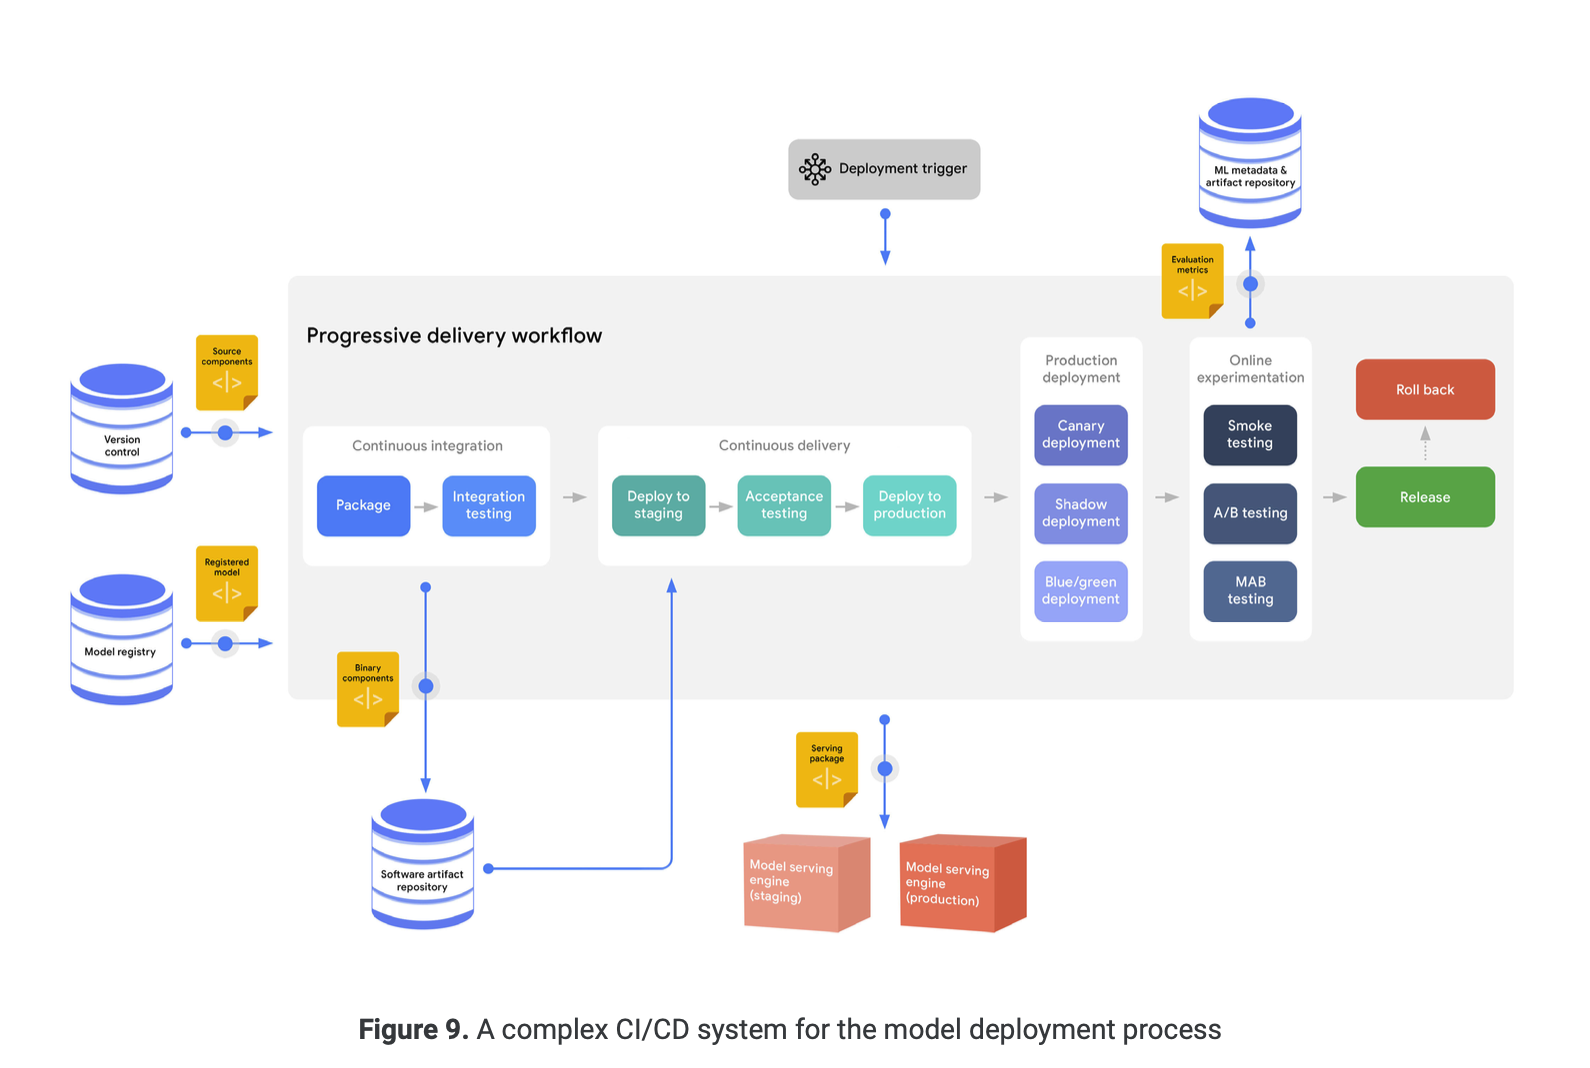

In [10]:
Image(
    "artifacts/complex_ci_cd_for_deployment.png",
    width=1000,
)

**Model deployment typically involves two main stages: Continuous Integration (CI) and Continuous Delivery (CD).**
- During the CI stage, the focus is on validating the model and its environment. This includes testing the model's interface to ensure it accepts the expected input format and produces the correct output. Additionally, compatibility checks are performed to verify that the model can run on the target infrastructure, including confirming the presence of required packages and hardware accelerators. Performance metrics such as model latency are also evaluated at this stage to ensure the model meets operational requirements.

- In the CD stage, the emphasis shifts to safely releasing the model into production through progressive delivery strategies. Techniques such as canary, blue-green, and shadow deployments are used to conduct smoke tests, which assess the model service's efficiency (e.g., latency and throughput) and monitor for service errors. Once the model is confirmed to function correctly from a technical perspective, its effectiveness is further validated in a live environment. This is achieved by gradually routing production traffic to the new model and running online experiments, allowing teams to observe real-world performance and impact before full-scale deployment.

```{note}
Online experimentation is particularly important in the context of ML. Deciding whether a new model candidate should replace the production version is a more complex and multi-dimensional task compared to deploying other software assets.
```

**Progressive Delivery and Online Experimentation**

- Progressive delivery is a deployment strategy in which a new model candidate is introduced to production gradually, rather than replacing the existing model all at once. After deployment, the new model operates alongside the current version, and only a subset of users is routed to the new model in controlled stages. This staged rollout is guided by online experiments, such as A/B testing or multi-armed bandit (MAB) testing, which help quantify the new model’s impact on key application metrics and objectives.

- The results of these experiments determine whether the new model should be fully promoted to production and replace the previous version. Techniques like canary and shadow deployments are commonly used to facilitate these online experiments, enabling teams to monitor performance, detect issues early, and ensure that the new model delivers the intended improvements before a complete rollout.

## CI/CD Pipeline for Training


```{mermaid}
flowchart TD
    A[Source Code Repository] --> B[CI Pipeline]
    B --> C[Unit Testing]
    B --> D[Integration Testing]
    B --> E[Build Training Pipeline]

    C --> F{Tests Pass?}
    D --> F
    E --> F

    F -->|No| G[Feedback to Developer]
    F -->|Yes| H[Store Artifacts]

    H --> I[CD Pipeline]
    I --> J[Deploy to Test Environment]
    J --> K[End-to-End Testing]
    K --> L{Pipeline Valid?}

    L -->|No| M[Rollback]
    L -->|Yes| N[Deploy to Staging]
    N --> O[Smoke Testing]
    O --> P{Ready for Production?}

    P -->|No| M
    P -->|Yes| Q[Deploy to Production]
    Q --> R[Monitor Pipeline Health]

    style A fill:#e3f2fd
    style B fill:#fff3e0
    style I fill:#fff3e0
    style Q fill:#c8e6c9
    style F fill:#ffecb3
    style L fill:#ffecb3
    style P fill:#ffecb3
```


```{tip} Deployment Configurations
For MLOps, ML engineers should be able to use configurations to deploy the ML pipelines. The configurations specify variables like:

- The target deployment environment (development, test, staging, etc.)
- The data sources to access during execution in each environment
- The service account to use for running compute workloads
- Compute resources and scaling parameters
- Security and access policies
```

A pipeline typically goes through a series of testing and staging environments before it is released to production. The number of testing and staging environments varies depending on standards established in the organization.

As illustrated in {numref}`training-operationalization-fig`, this process ensures quality and reliability through systematic validation at each stage.


## Continuous Integration (CI) Deep Dive

### CI Testing Strategies


```{important} Comprehensive CI Testing
The CI process should include multiple types of tests:

**Unit Testing:**

- Test feature engineering logic and data transformation functions
- Test individual model components and methods (e.g., categorical encoding functions)
- Validate mathematical operations and statistical computations

**Integration Testing:**

- Test integration between pipeline components
- Verify data flow between pipeline steps
- Test component interfaces and contracts

**Model Testing:**

- Test that model training converges (loss decreases over iterations)
- Test model training doesn't produce NaN values
- Test model can overfit on a few sample records (sanity check)
- Validate that each component produces expected artifacts
```


### CI Workflow Details

```{mermaid}
flowchart LR
    A[Code Commit] --> B[Trigger CI]
    B --> C[Code Checkout]
    C --> D[Environment Setup]
    D --> E[Dependency Installation]

    E --> F[Unit Tests]
    E --> G[Integration Tests]
    E --> H[Model Tests]
    E --> I[Code Quality Checks]

    F --> J[Collect Results]
    G --> J
    H --> J
    I --> J

    J --> K{All Tests Pass?}
    K -->|No| L[Notify Developer]
    K -->|Yes| M[Build Artifacts]

    M --> N[Store in Registry]
    N --> O[Trigger CD]

    style A fill:#e1f5fe
    style B fill:#fff3e0
    style M fill:#fff8e1
    style O fill:#c8e6c9
    style K fill:#ffecb3
```


```{warning} Common CI Test Failures
Watch out for these common issues:

- **Dependency conflicts:** Version mismatches between development and CI environments
- **Data schema changes:** Tests failing due to unexpected data format changes
- **Resource limitations:** Tests failing due to insufficient compute or memory in CI environment
- **Flaky tests:** Non-deterministic failures due to random seeds or timing issues
```


## Continuous Delivery (CD) Deep Dive

### Multi-Environment Strategy

```{tip} Environment Progression
**Test Environment:**

- Automated deployment triggered by successful CI
- Run on subset of production data
- Focus on functionality and integration testing

**Staging Environment:**

- Semi-automated deployment (requires approval)
- Mirror of production environment
- Full-scale testing with production-like data volumes

**Production Environment:**

- Manual deployment with additional approvals
- Gradual rollout with monitoring and rollback capabilities
- Full production data and traffic
```


### CD Validation Checklist

Before deploying to each environment, the CD process should verify:

```{important} Pre-Deployment Validation
**Infrastructure Compatibility:**

- Required packages and dependencies are available
- Compute resources (CPU, GPU, memory) are sufficient
- Storage and networking requirements are met
- Security permissions and service accounts are properly configured

**Model Compatibility:**

- Model accepts expected input format
- Model produces expected output format
- Model latency meets performance requirements
- Model size is within deployment limits

**Data Validation:**

- Training data quality checks pass
- Data schema matches expectations
- Feature distributions are within acceptable ranges
- No data leakage or privacy violations
```


## Environment Flow

```{mermaid}
graph TD
    A[Source Code Changes] --> B[CI Pipeline]
    B --> C{CI Tests Pass?}
    C -->|No| D[Developer Notification]
    C -->|Yes| E[Automated Deploy to Test]

    E --> F[Test Environment Validation]
    F --> G{Test Results OK?}
    G -->|No| H[Fix and Retry]
    G -->|Yes| I[Semi-Automated Deploy to Staging]

    I --> J[Staging Environment Testing]
    J --> K[Performance Benchmarking]
    K --> L[Security Validation]
    L --> M{Staging Validation Complete?}

    M -->|No| N[Investigation Required]
    M -->|Yes| O[Manual Production Deployment]

    O --> P[Production Smoke Tests]
    P --> Q[Gradual Traffic Ramp]
    Q --> R[Full Production Deployment]

    style A fill:#e1f5fe
    style E fill:#fff3e0
    style I fill:#fff8e1
    style O fill:#ffb74d
    style R fill:#c8e6c9
```


## Technology-Specific Considerations

```{note} Implementation Approaches
**No-Code/Low-Code Solutions:**

- Deployment process is streamlined and abstracted
- Data scientists don't handle deployment details
- Platform handles infrastructure provisioning automatically

**Code-First Approaches:**

- More flexibility and control over ML pipelines
- Requires expertise in CI/CD tools and practices
- Enables custom testing and deployment strategies
- Better suited for complex, custom ML workflows
```

### Pipeline Deployment Artifacts

```{seealso} Typical Assets Produced
**Training Pipeline Executables:**

- Container images stored in container registries
- Python packages or JAR files in artifact repositories
- Configuration files and environment specifications

**Pipeline Runtime Representation:**

- Workflow definitions (e.g., Kubeflow, Airflow DAGs)
- Pipeline metadata and dependency graphs
- Resource requirements and scaling configurations
```


### Fallback and Recovery Strategies

```{warning} Production Safety Measures
**Deployment Safety:**

- Smoke testing of newly deployed pipelines
- Automatic fallback to previous pipeline version on failure
- Blue-green deployment strategies for zero-downtime updates
- Canary deployments for gradual rollout

**Monitoring and Alerting:**

- Pipeline execution monitoring and logging
- Performance metrics tracking (execution time, resource usage)
- Automated alerts for pipeline failures or anomalies
- Integration with incident management systems
```


---

```{seealso} Core MLOps Capabilities
- **ML pipelines:** Orchestration and automation platform
- **Source control:** Version control for all pipeline code and configurations
- **CI/CD systems:** Automated testing and deployment infrastructure
- **Artifact repositories:** Storage for pipeline components and dependencies
- **Environment management:** Provisioning and configuration of deployment targets
```

```{tip} Best Practices for Training Operationalization
- **Infrastructure as Code:** Use tools like Terraform to provision ML platform environments
- **Configuration Management:** Externalize all environment-specific configurations
- **Automated Testing:** Implement comprehensive testing at multiple levels
- **Progressive Deployment:** Use staging environments to validate before production
- **Monitoring and Logging:** Implement observability from day one
- **Documentation:** Maintain clear documentation for all pipeline components and processes
- **Security:** Implement security scanning and compliance checks in CI/CD
- **Resource Optimization:** Monitor and optimize compute resource usage
```
